In [1]:
import random
import string
import re
import nltk
import torch

import copy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

from nlp_project.notebook_utils import evaluate, split, save_scikit_model, load_scikit_model
from nlp_project.nn_utils import init_gpu
from nlp_project.nn_classifier import Data, Classifier
from nlp_project.nn_extra import EarlyStopping, AdaptLR

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [3]:
# Saved Models path
models_path = "./models/T1_BoW_Models"

# Classification labels
labels = ["generated", "human"]

In [4]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,you need to stop the engine and wait until it ...,generated
1,The Commission shall publish the report; an in...,generated
2,"I have not been tweeting a lot lately, but I d...",generated
3,I pass my exam and really thankgod for that bu...,human
4,The template will have 3 parts: a mustache sha...,human
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",human
33841,10. Article 13 of Council Directive 80/777/EEC...,human
33842,"Crying because I have to cry for you?. No. No,...",generated
33843,"However, it will continue to offer customers a...",generated


In [5]:
def preprocess(data, lower=True, vectorizer=None, fit=True):
    # Convert all text to lowercase
    if lower:
        data = [x.lower() for x in data]

    # Remove punctuation and reset multiple spaces to one
    punct_regex = re.compile("[" + string.punctuation + "\’'" + "]")
    whitespace_regex = re.compile(" ( )+")
    data = [whitespace_regex.sub(" ", punct_regex.sub(" ", x)) for x in data]
    
    # Vectorize
    if vectorizer:
        if fit:
            data = vectorizer.fit_transform(data)
        else:
            data = vectorizer.transform(data)
    
    return data

In [6]:
# CountVectorizer leads to comparable results
# Setting min_df < 4 leads to comparable results but with much more parameters
# NOT removing stopwords results in an overall increase in accuracy of 0.02 - 0.04
# bigrams boost the performance by a little amount

# vectorizer = CountVectorizer(stop_words="english")
# vectorizer = TfidfVectorizer(min_df=4, max_df=0.6, stop_words="english")
vectorizer = TfidfVectorizer(min_df=4, max_df=0.6, ngram_range=(2,2))

In [7]:
x, y = df["text"], df["label"]
x_train, x_val, x_test, y_train, y_val, y_test = split(
    x, y, test_size=0.2, val_size=0.0, seed=seed
)
x_train = preprocess(x_train, vectorizer=vectorizer)
x_test = preprocess(x_test, vectorizer=vectorizer, fit=False)

In [8]:
models = []
usecached = False

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Naive Bayes",
    "model": nb_clf,
    "usecached": usecached,
})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Linear Regression",
    "model": lr_clf,
    "subsample": 0.7,
    "usecached": usecached,
})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "SVC",
    "model": svc_clf,
    "subsample": 0.7,
    "usecached": usecached,
})

# Decision Tree
dtree = DecisionTreeClassifier()
dtree_param = {
    "criterion": ["gini", "entropy"], 
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
}
dtree_clf =  GridSearchCV(dtree, dtree_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Decision Tree",
    "model": dtree_clf,
    "usecached": usecached,
})

# Random Forest
rf = RandomForestClassifier()
rf_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
rf_clf =  GridSearchCV(rf, rf_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Random Forest",
    "model": rf_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

# Extra Trees
et = ExtraTreesClassifier()
et_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
et_clf =  GridSearchCV(et, et_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Extra Trees",
    "model": et_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

In [9]:
for model in models:
    if model["usecached"]:
        cache = load_scikit_model(models_path, model["name"])
        if cache:
            model["best"] = cache
            print(f"Restored model for {model['name']}")
            continue
        else:
            print(f"Couldn't restore model for {model['name']}")
            
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
            
    print(f"Training {model['name']}")        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")
    
    save_scikit_model(models_path, model["best"], model["name"])

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 0.1}
Best CV score: 0.7271383377591923
              precision    recall  f1-score   support

   generated       0.67      0.84      0.75      3360
       human       0.79      0.60      0.68      3409

    accuracy                           0.72      6769
   macro avg       0.73      0.72      0.71      6769
weighted avg       0.73      0.72      0.71      6769



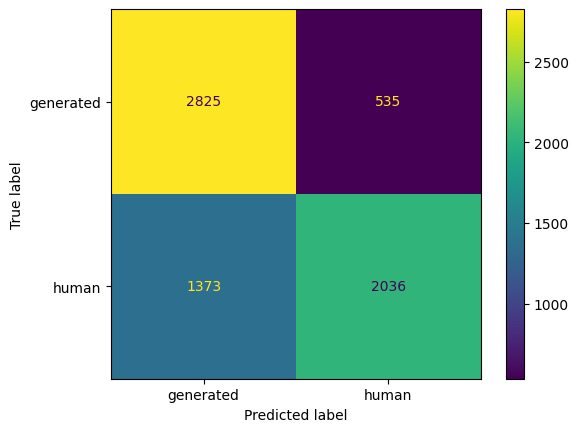

Linear Regression
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.7407030693444486
              precision    recall  f1-score   support

   generated       0.75      0.77      0.76      3360
       human       0.77      0.75      0.76      3409

    accuracy                           0.76      6769
   macro avg       0.76      0.76      0.76      6769
weighted avg       0.76      0.76      0.76      6769



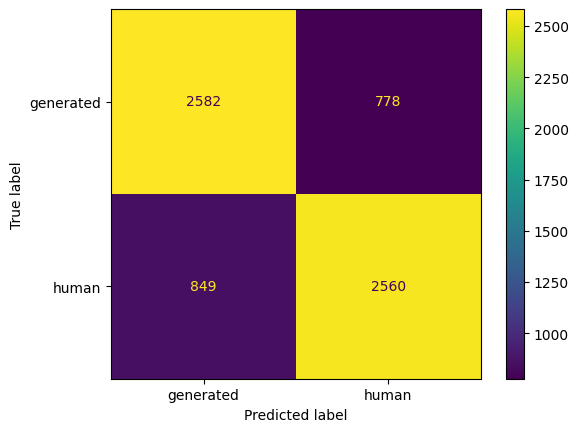

SVC
Best parameters: {'C': 1, 'kernel': 'rbf'}
Best CV score: 0.7373805987116331
              precision    recall  f1-score   support

   generated       0.76      0.76      0.76      3360
       human       0.77      0.77      0.77      3409

    accuracy                           0.76      6769
   macro avg       0.76      0.76      0.76      6769
weighted avg       0.76      0.76      0.76      6769



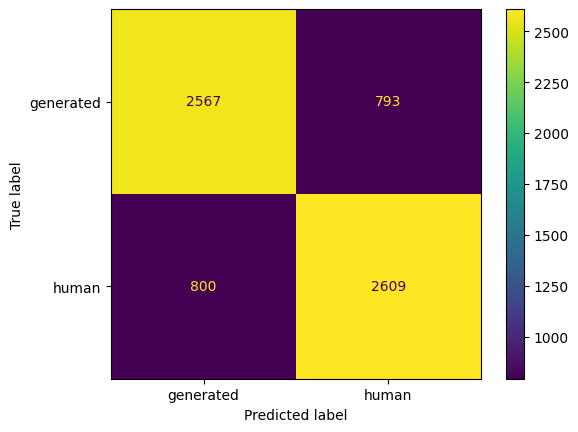

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.7033534917913613
              precision    recall  f1-score   support

   generated       0.70      0.69      0.69      3360
       human       0.70      0.71      0.70      3409

    accuracy                           0.70      6769
   macro avg       0.70      0.70      0.70      6769
weighted avg       0.70      0.70      0.70      6769



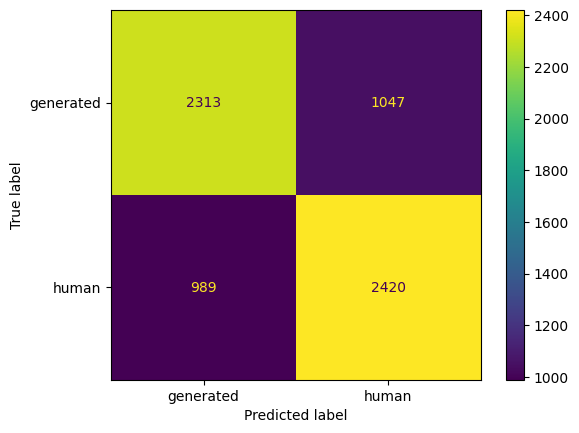

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7397045244690673
              precision    recall  f1-score   support

   generated       0.75      0.76      0.76      3360
       human       0.76      0.75      0.76      3409

    accuracy                           0.76      6769
   macro avg       0.76      0.76      0.76      6769
weighted avg       0.76      0.76      0.76      6769



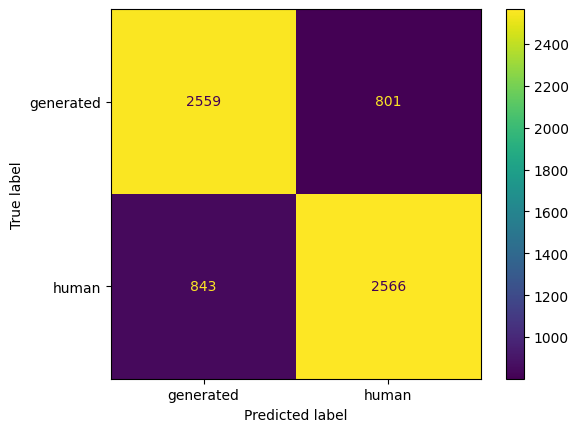

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.753185595567867
              precision    recall  f1-score   support

   generated       0.75      0.77      0.76      3360
       human       0.77      0.74      0.75      3409

    accuracy                           0.76      6769
   macro avg       0.76      0.76      0.76      6769
weighted avg       0.76      0.76      0.76      6769



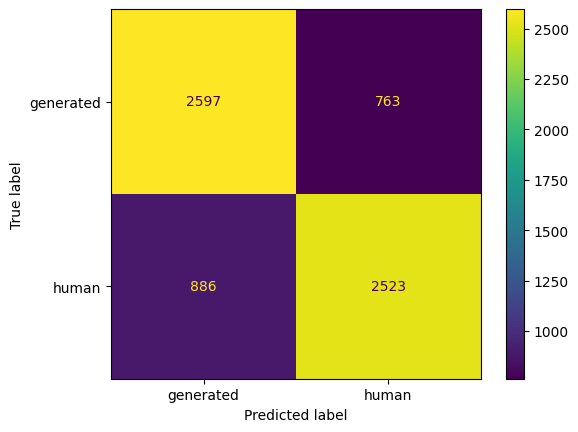

In [10]:
for model in models:
    print(f"{model['name']}")
    if hasattr(model["model"], "cv_results_"):
        print(f"Best parameters: {model['model'].best_params_}")
        print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [11]:
epochs = 100
batch_size = 32

num_workers = 8 # Tune it based on your machine specs
device = init_gpu()

In [12]:
y_ = LabelBinarizer().fit_transform(y).astype(float)

x_train, x_val, x_test, y_train, y_val, y_test = split(
    x, y_, test_size=0.1, val_size=0.1, seed=seed
)

x_train = preprocess(x_train, vectorizer=vectorizer)
x_val = preprocess(x_val, vectorizer=vectorizer, fit=False)
x_test = preprocess(x_test, vectorizer=vectorizer, fit=False)

In [13]:
ds_train = Data(x_train, y_train, x_type=np.float32)
ds_val = Data(x_val, y_val, x_type=np.float32)
ds_test = Data(x_test, y_test, x_type=np.float32)

train_dl = dt.DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
val_dl = dt.DataLoader(ds_val,     
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
test_dl = dt.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

/home/riga/Documents/NLP/NLP_Project/nlp_project/nn_classifier.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  torch.LongTensor([x_coo.row, x_coo.col]),


In [14]:
in_dim = x_train.shape[1]
out_dim = 1 if len(labels) <= 2 else len(labels)

In [15]:
class Network(Classifier):
    def __init__(self, in_dim, out_dim, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__(binary_classifier, device, verbose)
        self.l1 = nn.Linear(in_dim, 256)
        self.l2 = nn.Linear(256, out_dim)
        self.dp = nn.Dropout(p=0.6)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dp(x)
        x = self.sig(self.l2(x))
        return x

In [16]:
nn_model = Network(in_dim, out_dim, binary_classifier=True, device=device)
loss = nn.BCELoss()
optimizer = opt.Adam(nn_model.parameters(), lr=0.01)
nn_model.compile(loss, optimizer)

In [17]:
earlystop = EarlyStopping(metric="val_acc", patience=10, baseline=0.7)
lradjust = AdaptLR(metric="val_acc", patience=5, factor=0.1)
callbacks = [earlystop, lradjust]

# nn_model.load_state_dict(torch.load(models_path + "NN Model"))
history = nn_model.train_loop(train_dl, epochs, data_val=val_dl, callbacks=callbacks)

Epoch 1 -- loss: 0.0148053 acc: 0.7504801 val_loss: 0.0140322 val_acc: 0.7663220
Epoch 2 -- loss: 0.0087805 acc: 0.8733565 val_loss: 0.0148845 val_acc: 0.7686854
Epoch 3 -- loss: 0.0047932 acc: 0.9383956 val_loss: 0.0176479 val_acc: 0.7648449
Epoch 4 -- loss: 0.0027340 acc: 0.9673881 val_loss: 0.0196140 val_acc: 0.7612998
Epoch 5 -- loss: 0.0017581 acc: 0.9780617 val_loss: 0.0241144 val_acc: 0.7488922
Epoch 6 -- loss: 0.0014472 acc: 0.9837125 val_loss: 0.0264207 val_acc: 0.7562777
Reducing lr to 0.0010
Epoch 7 -- loss: 0.0011197 acc: 0.9878490 val_loss: 0.0285832 val_acc: 0.7485967
Epoch 8 -- loss: 0.0006727 acc: 0.9917639 val_loss: 0.0277288 val_acc: 0.7506647
Epoch 9 -- loss: 0.0006377 acc: 0.9919855 val_loss: 0.0288098 val_acc: 0.7530281
Epoch 10 -- loss: 0.0006109 acc: 0.9923549 val_loss: 0.0318159 val_acc: 0.7497784
Epoch 11 -- loss: 0.0005491 acc: 0.9930566 val_loss: 0.0336593 val_acc: 0.7515510
Model restored successfully @ epoch 2


{'acc': tensor(0.7556), 'loss': 0.015244170789987764}
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75      1680
         1.0       0.75      0.77      0.76      1704

    accuracy                           0.76      3384
   macro avg       0.76      0.76      0.76      3384
weighted avg       0.76      0.76      0.76      3384



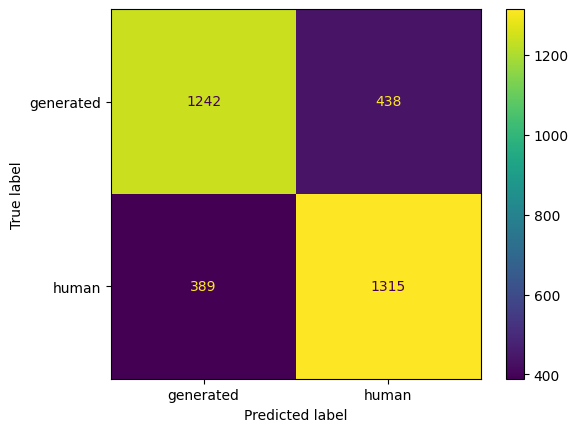

In [18]:
y_pred, metrics = nn_model.test_loop(test_dl)
print(metrics)
evaluate(y_test, y_pred, labels=labels)

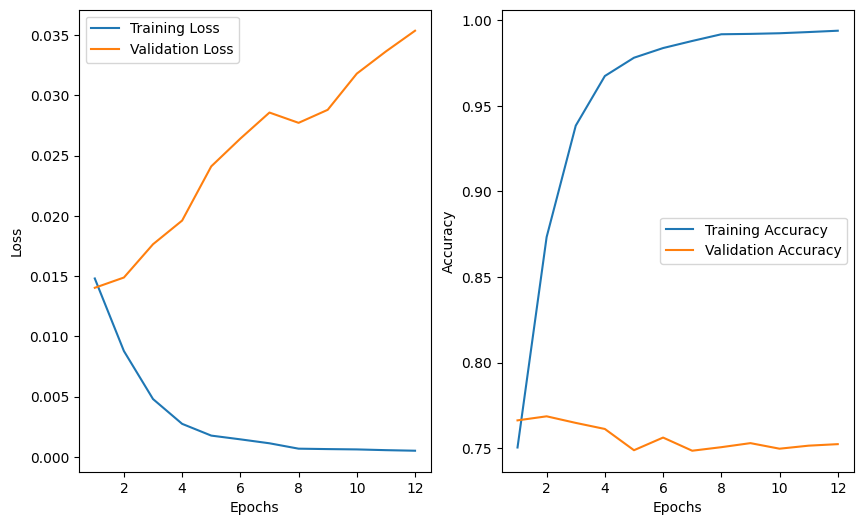

In [19]:
history = nn_model.history
plt_epochs = [h["epoch"] for h in history]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

tl = ax1.plot(plt_epochs, [h["loss"] for h in history], label="Training Loss")
vl = ax1.plot(plt_epochs, [h["val_loss"] for h in history], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ta = ax2.plot(plt_epochs, [h["acc"] for h in history], label="Training Accuracy")
va = ax2.plot(plt_epochs, [h["val_acc"] for h in history], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

In [20]:
torch.save(nn_model.state_dict(), models_path + "/" + "NN Model")